In [37]:
# imports
from tqdm import tqdm
import random
import os
import time
# Turn off tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# For Data Processing & ML Models
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, ImageEnhance
import cv2

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Enable offline usage of plotly
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

from IPython.display import clear_output
clear_output()


**For uniform results, random seed is required**

In [38]:
tf.random.set_seed(100)
np.random.seed(100)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# 1. EDA

In [39]:
path = "/kaggle/input/cxr-for-cptn/Dataset/"
os.listdir(path)

['PNEUMONIA', 'TUBERCULOSIS', 'NORMAL', 'COVID-19']

## Distibution of data

In [40]:
# Define the directory paths
all_paths = []
all_labels = []
for label in os.listdir(path):
    label_dir = os.path.join(path, label)
    for image in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image)
        all_paths.append(image_path)
        all_labels.append(label)
all_paths, all_labels = shuffle(all_paths, all_labels)
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame({'path':all_paths, 'label':all_labels})
df.head()

,path,label
0,/kaggle/input/cxr-for-cptn/Dataset/TUBERCULOSIS/Tuberculosis-185.png,TUBERCULOSIS
1,/kaggle/input/cxr-for-cptn/Dataset/PNEUMONIA/person1358_bacteria_3465.jpeg,PNEUMONIA
2,/kaggle/input/cxr-for-cptn/Dataset/NORMAL/IM-0261-0001.jpeg,NORMAL
3,/kaggle/input/cxr-for-cptn/Dataset/PNEUMONIA/person257_virus_538.jpeg,PNEUMONIA
4,/kaggle/input/cxr-for-cptn/Dataset/PNEUMONIA/person1644_bacteria_4357.jpeg,PNEUMONIA


In [41]:
print("shape of data:",df.shape)
print("------------------------------------")
print("Column names:", df.columns)

shape of data: (10172, 2)
------------------------------------
Column names: Index(['path', 'label'], dtype='object')


In [42]:
df['label'].value_counts()

PNEUMONIA       4273
COVID-19        3616
NORMAL          1583
TUBERCULOSIS     700
Name: label, dtype: int64

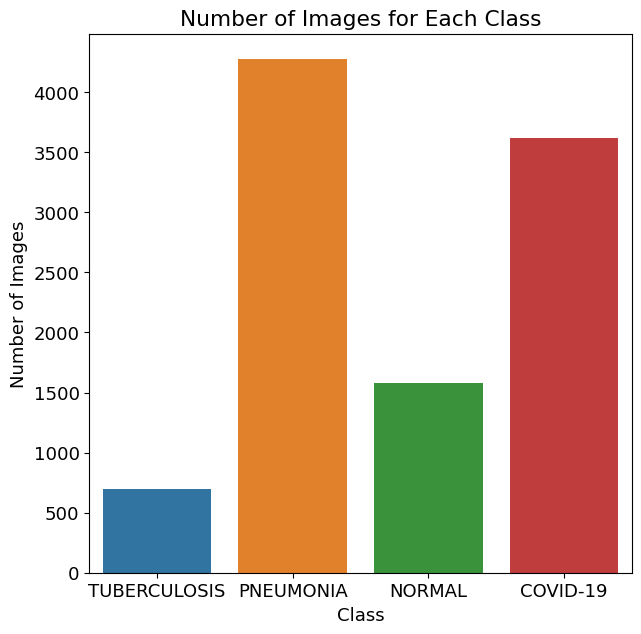

In [43]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(7,7))
sns.countplot(x = df['label'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images for Each Class')
plt.show()

## Splitting the data into train, test and validation : 80%, 10% and 10%

It is generally recommended to split the data into train, test, and validation sets before preprocessing the data. This is because preprocessing techniques such as normalization, scaling, and feature selection are often based on the statistics of the training set, and applying these techniques before splitting the data can lead to data leakage and overfitting

In [44]:
from sklearn.model_selection import train_test_split
# Split the data into train and test sets with stratified sampling
train_val, test_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)
# Split the train set into train and validation sets with stratified sampling
train_df, val_df = train_test_split(train_val, test_size=0.1, stratify=train_val['label'], random_state=42)

In [45]:
print("Original train+val set:", train_val.shape)
print("Train set:",train_df.shape)
print("Test set:",test_df.shape)
print("Val set:",val_df.shape)

Original train+val set: (9154, 2)
Train set: (8238, 2)
Test set: (1018, 2)
Val set: (916, 2)


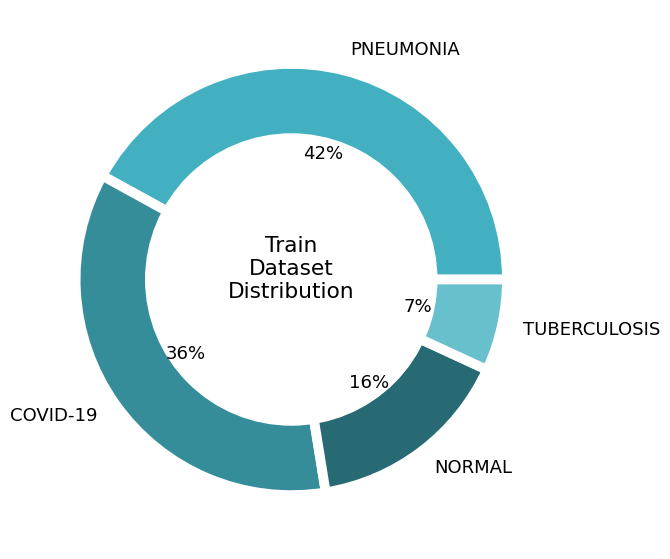

In [46]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(7,7))
# plotting data on chart
plt.pie(list(df.label.value_counts()),
        labels=list(train_df.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Train\nDataset\nDistribution', x=0.5, y=0.45) 
plt.show()

From the total dataset distribution, pneumonia images accounts for more that half of the dataset with 42% while tuberculosis instances accounts for only 7% ot the total dataset. Other classes for normal and Covid-19 accounts for 16% and 36% respectively. 

# 2. Pre-processing
Image Augmentation is a process that is used to create new images for training by slightly altering the pixel values.
We have a small dataset, so we can apply some image augmentation techniques to prevent overfitting of the model.
Techniques we will be using are:

1. Change the brightness of an image by a factor between 0.67 to 1.33
2. Change the contrast of an image by a factor between 0.67 to 1.33

In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
class configurations:
    IMAGE_SIZE = 224
    BRIGHTNESS = (0.64, 1.37) # (MIN, MAX)
    CONTRAST = (0.64, 1.37) # (MIX, MAX)
    BATCH_SIZE = 32
    EPOCHS = 10
    LEARNING_RATE = 0.001
def augment_image(image):
    datagen = ImageDataGenerator(
        brightness_range=configurations.BRIGHTNESS,
        #contrast_range=configurations.CONTRAST,
        #horizontal_flip=True,
        #vertical_flip=True,
        #rotation_range=20,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #shear_range=0.2,
        #zoom_range=0.2
    )
    # Convert input image from numpy to PIL Image
    image = np.expand_dims(image, axis=0)
    # Apply Transformations
    image = datagen.flow(image, batch_size=1)[0][0]
    return image

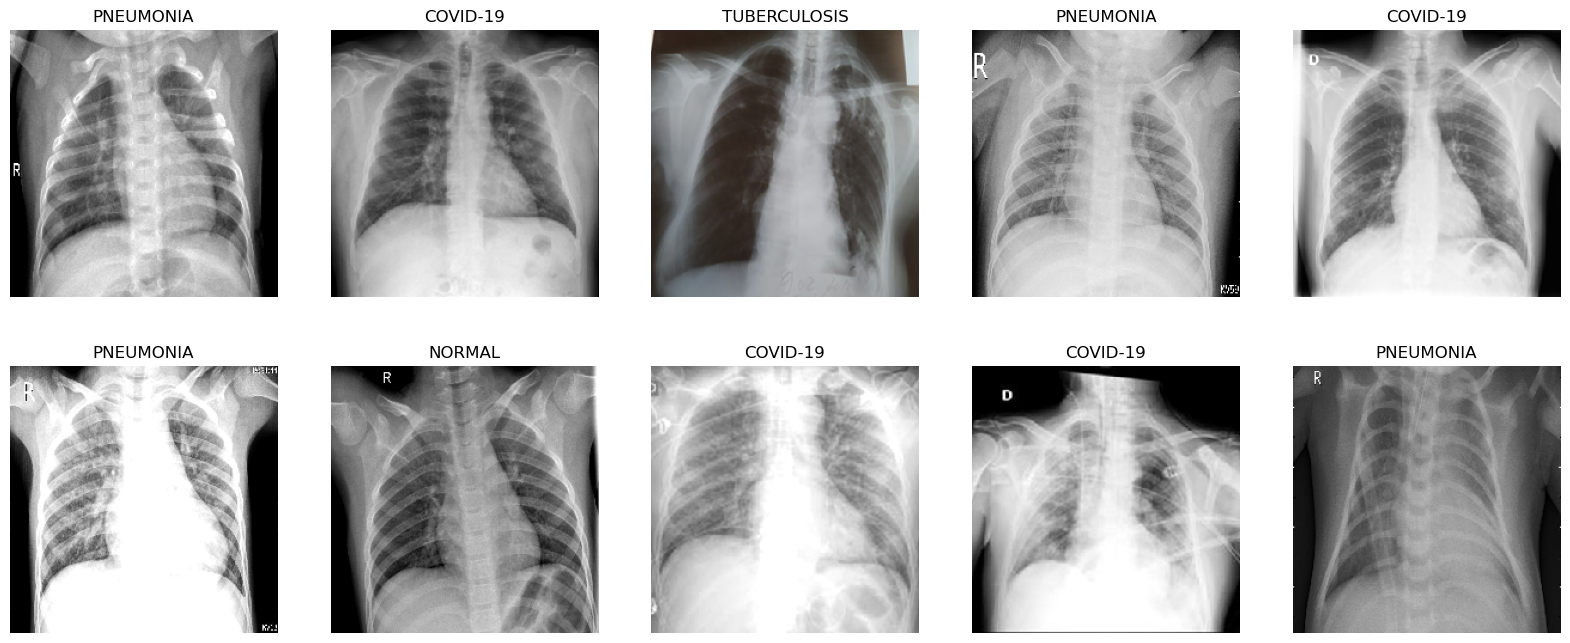

In [48]:
def open_images(paths, augment=True):
    '''
    Given a list of paths to images, this function returns the images as arrays, and conditionally augments them
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(configurations.IMAGE_SIZE,configurations.IMAGE_SIZE))
        if augment:
            image = augment_image(image)
        image = np.array(image)
        image = image/image.max()
        images.append(image)
    return np.array(images)

# Randomly select and plot a few images with augmentation
k = random.randint(0,5000)
image_paths = list(train_df.path[k:k+10])
labels = list(train_df.label[k:k+10])
images = open_images(image_paths, augment=True)
plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(20, 8))

for i in range(0, 10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(labels[i])
plt.show()

## 2.1 Label encoder-decoder
1. Creating a dictionary label_encoder to convert string label to interger-encoded label
2. And another dictionary label_decoder to decode the integer-encoded label

In [49]:
LABELS = ['NORMAL', 'TUBERCULOSIS', 'PNEUMONIA', 'COVID-19']
label_encoder = {'NORMAL': 0, 'TUBERCULOSIS': 1, 'PNEUMONIA': 2, 'COVID-19': 3}
label_decoder = {0: 'NORMAL', 1: 'TUBERCULOSIS', 2: 'PNEUMONIA', 3: 'COVID-19'}

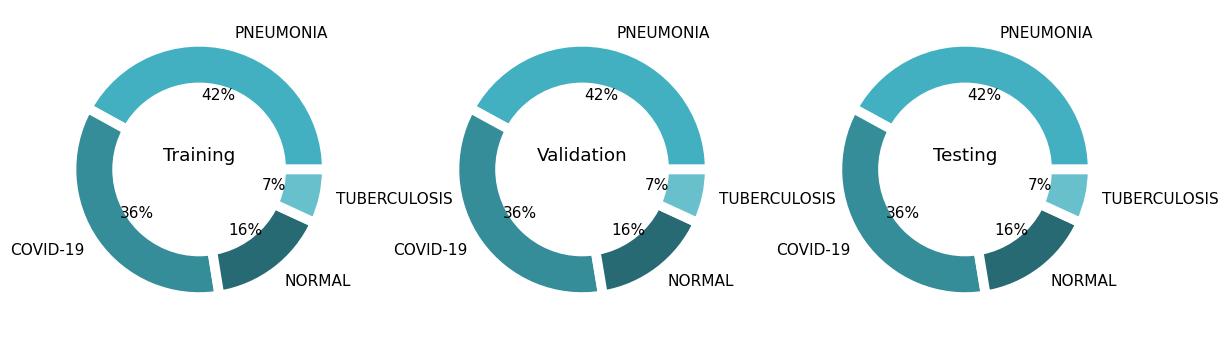

In [50]:
plt.rcParams.update({'font.size': 11})
fig = plt.figure(figsize=(14, 7))

fig.add_subplot(1, 3, 1)
plt.pie(list(train_df.label.value_counts()),
        labels=list(train_df.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Training', x=0.5, y=0.5) 


fig.add_subplot(1, 3, 2)
plt.pie(list(val_df.label.value_counts()),
        labels=list(val_df.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Validation', x=0.5, y=0.5) 

fig.add_subplot(1, 3, 3)
plt.pie(list(test_df.label.value_counts()),
        labels=list(test_df.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Testing', x=0.5, y=0.5) 
plt.show()

Training a model on this highly imbalanced dataset will cause the model to overfit on the class that is in excess and fail to learn patterns from other classes. Fortunately, there are ways to tackle this problem. What we will be doing is assigning "class weights" to the classes, to handle the imbalanced classes. This will be computed in the later sections

## 2.3 Data Generators
data_generator is the generator function which we will use for training. It has 4 input parameters:

1. > df: This is the dataframe containing the image paths and labels \n
1. > batch_size (int): Batch size of training samples
1. > augment (boolean): If true, the augmentation techniques defined before will be applied to the images. We will set this to True during training and False during validation
1. > epochs (int): Number of epochs

In [51]:
def data_generator(df, batch_size=configurations.BATCH_SIZE, augment=True, epochs=configurations.EPOCHS):
    for e in range(epochs):
        for x in range(0,len(df), batch_size):
            image_paths = df.path[x:x+batch_size]
            images = open_images(image_paths, augment=augment)
            labels = df.label[x:x+batch_size]
            labels = [label_encoder[label] for label in labels]
            yield images, np.array(labels)

In [52]:
# Creating generators for training and validation. You can change the parameters in the configuration section.
train_data_generator = data_generator(train_df, batch_size=configurations.BATCH_SIZE, augment=True, epochs=configurations.EPOCHS)
train_steps = int(len(train_df)/configurations.BATCH_SIZE)

val_data_generator = data_generator(val_df, batch_size=configurations.BATCH_SIZE, augment=False, epochs=configurations.EPOCHS)
val_steps = int(len(val_df)/configurations.BATCH_SIZE)

# 3. Model

## 3.1 Model architecture 
* We are utilizing the inspiration of ResNet-50 model

In [53]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D,MaxPooling2D, Dropout, Flatten, Activation, Input, Add

In [54]:
resnet_model= ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))
for layer in resnet_model.layers[:-10]:
    layers.trainable=False
hm = resnet_model.output
hm = AveragePooling2D(pool_size=(4,4))(hm)
hm = Flatten(name = 'flatten')(hm)
hm = Dense(256, activation = 'relu')(hm)
hm = Dropout(0.3)(hm)
hm = Dense(128, activation = 'relu')(hm)
hm = Dropout(0.2)(hm)
hm = Dense(4,activation = 'softmax')(hm)

model = Model(inputs=resnet_model.input, outputs = hm)

94765736/94765736 [==============================] - 4s 0us/step


In [55]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## 3.2 Compile

This is the loss function we will be using:  

$$\mathcal{L}_{cross-entropy} = -\cfrac{1}{N}\sum_{i=1}^N [y_i\text{log}(\hat y_i) + (1-y_i)\text{log}(1-\hat y_i)]$$
where,  
$\quad\hat y$ is the predicted label, and $y$ is the actual label  
$\quad y_i$ is the $i^\mathbf{th}$ sample of $y$  and $\hat y_i$ is the $i^\mathbf{th}$ sample of $\hat y$  
$\quad N$ is the number of samples

`sparse_categorical_crossentropy` and `categorical_crossentropy` are basically the same loss functions, just their input formats are different.  
If $y_i$ is <b><mark>one-hot encoded</mark></b>, we use `categorical_crossentropy`, and if $y_i$ is <b><mark>integer-encoded</mark></b>, we use `sparse_categorical_crossentropy`  
For our case, the labels from the data generators are <b><mark>integer-encoded</mark></b>, so we are using `sparse_categorical_crossentropy`  

In [56]:
from tensorflow.keras.optimizers import SGD
sgd_optimizer = SGD(configurations.LEARNING_RATE)
model.compile(optimizer=sgd_optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

#model.compile(optimizer=optimizers.Adam(learning_rate=cfg.LEARNING_RATE),
#            loss='sparse_categorical_crossentropy',
#             metrics=['accuracy'])

# 3.3 Training the model
As said earlier, we will be using 'class weights' to tackle the imbalanced dataset problem. Using the cross-entropy loss function will create a bias towards the dominating class. So, we will apply multipliers, or 'weights' to balance the loss function. This is called a <b><mark>weighted loss function</mark></b>:  
$$\mathcal{L}_{cross-entropy} = -\cfrac{1}{N}\sum_{i=1}^N [w_p y_i\text{log}(\hat y_i) + w_n (1-y_i)\text{log}(1-\hat y_i)]$$

So how do you calculate these so called weights $w_p$ and $w_n$ for each class? Just calculate the proportion of the dataset each class represents and tensorflow will handle the rest.  
`class_weights` is a dictionary of format `{'CLASS':'PROPORTION'}`

## 1. Handling class imbalance with class weighting approach

In [57]:
class_weights = (train_df.label.value_counts() / len(train_df)).to_dict()
class_weights = dict((label_encoder[key], value) for (key, value) in class_weights.items())
class_weights

{2: 0.420004855547463,
 3: 0.35542607428987616,
 0: 0.15574168487496964,
 1: 0.06882738528769118}

In [58]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/model.hdf5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max', verbose=1,
    save_best_only=True)

history = model.fit(train_data_generator, epochs=configurations.EPOCHS, steps_per_epoch=train_steps, class_weight=class_weights,
          validation_data=val_data_generator, validation_steps=val_steps, callbacks=[model_checkpoint_callback])

Epoch 1/10
257/257 [==============================] - ETA: 0s - loss: 0.2781 - accuracy: 0.5714
Epoch 1: val_accuracy improved from -inf to 0.35826, saving model to /kaggle/working/model.hdf5
257/257 [==============================] - 157s 517ms/step - loss: 0.2781 - accuracy: 0.5714 - val_loss: 1.3163 - val_accuracy: 0.3583
Epoch 2/10
257/257 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.7659
Epoch 2: val_accuracy did not improve from 0.35826
257/257 [==============================] - 93s 355ms/step - loss: 0.1376 - accuracy: 0.7659 - val_loss: 1.3994 - val_accuracy: 0.3560
Epoch 3/10
257/257 [==============================] - ETA: 0s - loss: 0.0923 - accuracy: 0.8293
Epoch 3: val_accuracy improved from 0.35826 to 0.44978, saving model to /kaggle/working/model.hdf5
257/257 [==============================] - 94s 365ms/step - loss: 0.0923 - accuracy: 0.8293 - val_loss: 1.4049 - val_accuracy: 0.4498
Epoch 4/10
257/257 [==============================] - ETA: 0s -

# 4. Evaluate the model

In [59]:
val_data_generator = data_generator(val_df, batch_size=configurations.BATCH_SIZE, augment=False, epochs=1)
val_steps = int(len(val_df)/configurations.BATCH_SIZE)

y_pred = []
y_true = []

for x,y in tqdm(val_data_generator, total=val_steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in pred:
        y_pred.append(label_decoder[i])
    for i in y:
        y_true.append(label_decoder[i])
clear_output()
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

    COVID-19     0.8740    1.0000    0.9328       326
      NORMAL     0.9821    0.7746    0.8661       142
   PNEUMONIA     0.9287    0.9818    0.9545       385
TUBERCULOSIS     1.0000    0.3810    0.5517        63

    accuracy                         0.9148       916
   macro avg     0.9462    0.7844    0.8263       916
weighted avg     0.9224    0.9148    0.9054       916



# 5. Conclusion and Deployment

1/1 [==============================] - 0s 448ms/step


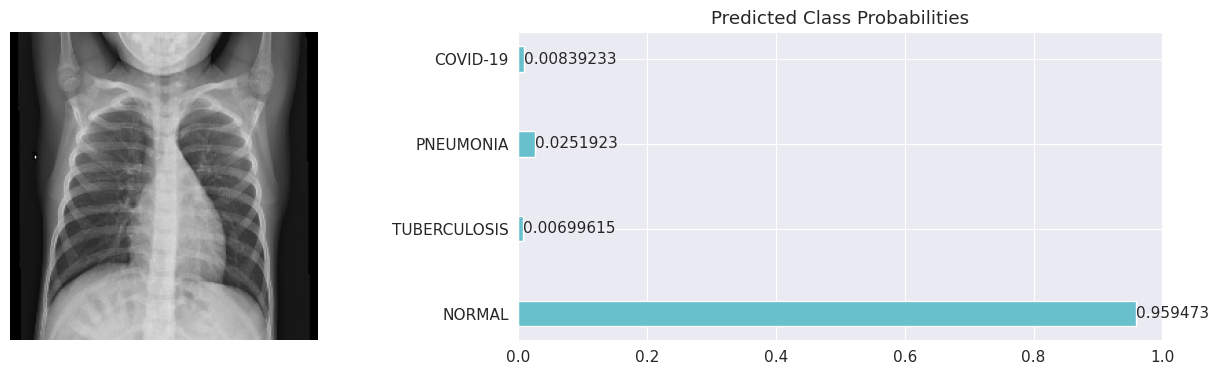

Actual   : NORMAL
Predicted: NORMAL
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 25ms/step


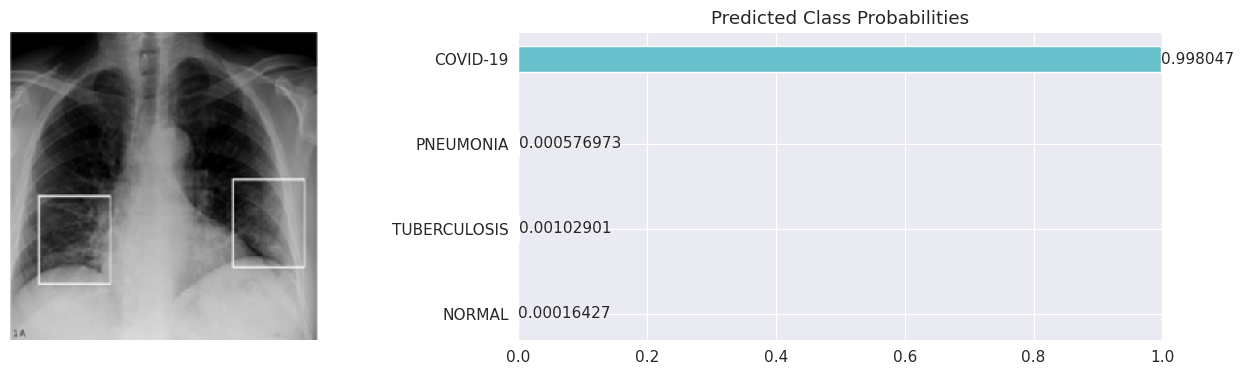

Actual   : COVID-19
Predicted: COVID-19
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 25ms/step


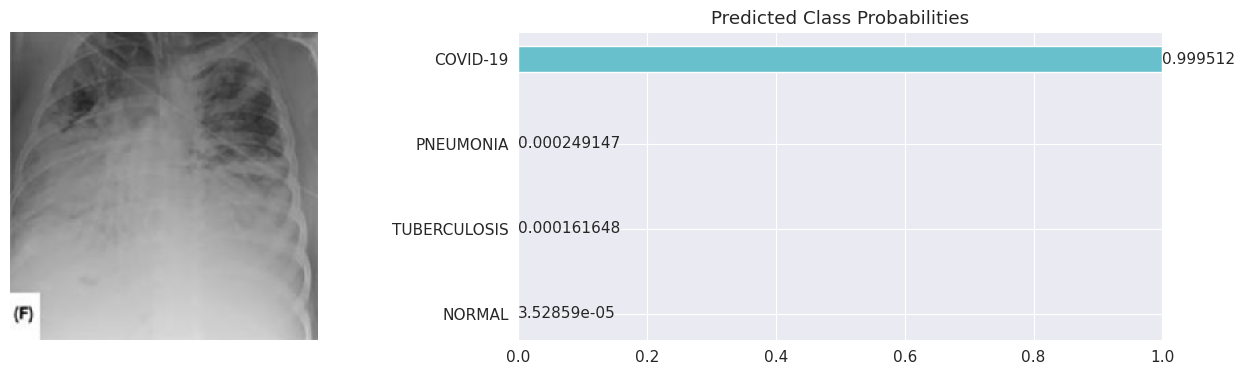

Actual   : COVID-19
Predicted: COVID-19
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 35ms/step


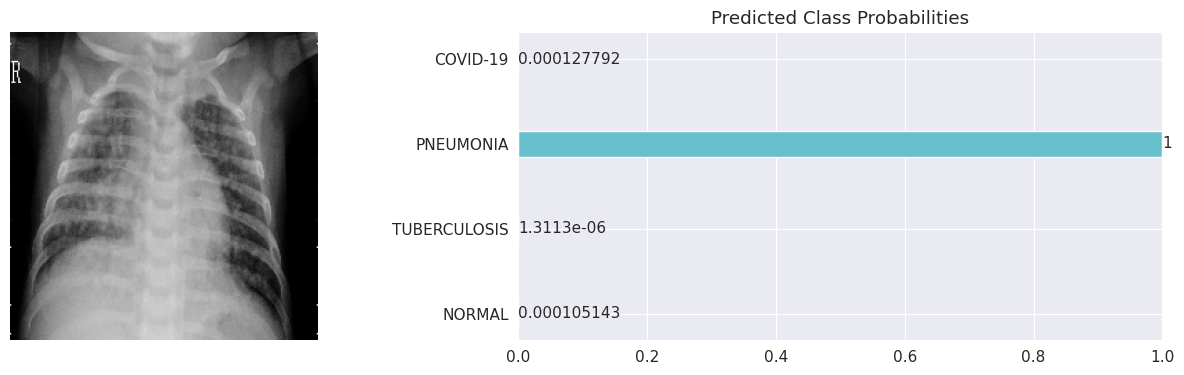

Actual   : PNEUMONIA
Predicted: PNEUMONIA
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 25ms/step


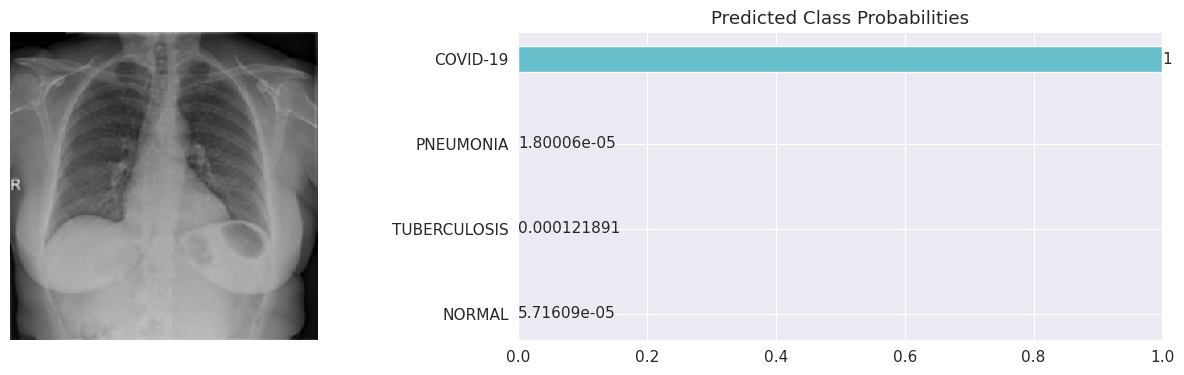

Actual   : COVID-19
Predicted: COVID-19
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 35ms/step


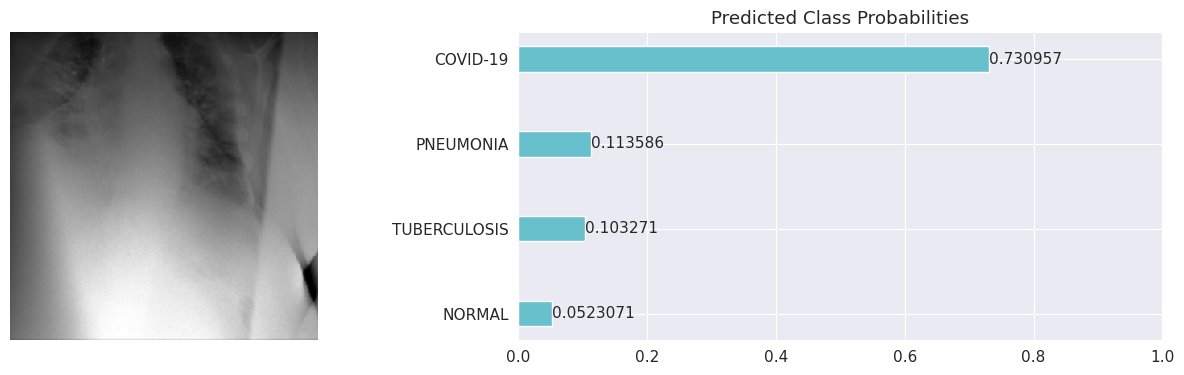

Actual   : COVID-19
Predicted: COVID-19
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 101ms/step


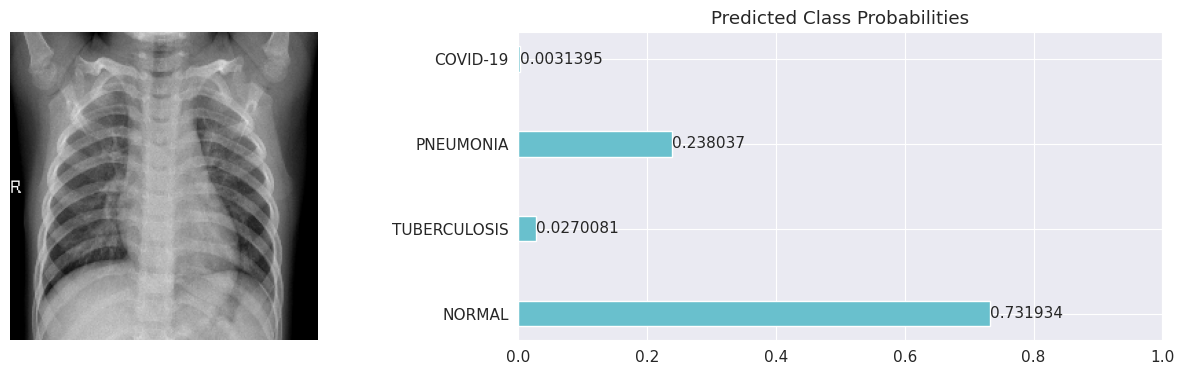

Actual   : NORMAL
Predicted: NORMAL
--------------------------------------------------------------------------------




In [60]:
def predict(image, model):
    '''
    Input the image and model, this function outputs the prediction as:
        1. The class with the highest probability
        2. A dictionary containing each class with their corresponding probability
    '''
    labels =  ['NORMAL', 'TUBERCULOSIS', 'PNEUMONIA', 'COVID-19']
    image = np.array(image)
    image = image/image.max()
    image = image.reshape(-1,configurations.IMAGE_SIZE,configurations.IMAGE_SIZE,3)
    probabilities = model.predict(image).reshape(-1)
    pred = labels[np.argmax(probabilities)]
    return pred, {x:y for x,y in zip(labels, probabilities)}

INDICES = random.sample(list(train_df.index), 7)

for INDEX in INDICES:

    image = load_img(train_df.path[INDEX], target_size=(configurations.IMAGE_SIZE, configurations.IMAGE_SIZE))
    pred, probabilities = predict(image, model)

    x = list(probabilities.keys())
    y = list(probabilities.values())

    sns.set_style("darkgrid")
    fig, ax = plt.subplots(1,2, figsize=(16,4), gridspec_kw={'width_ratios': [3, 4]})
    ax[0].imshow(image)
    ax[0].axis('off')

    bars = ax[1].barh(x, y, height=0.3, color=['#69c0cd', '#69c0cd', '#69c0cd', '#69c0cd'])
    ax[1].bar_label(bars)
    
    ax[1].set_title('Predicted Class Probabilities')
    plt.xlim([0, 1])
    plt.show()

    print('Actual   :',train_df.label[INDEX])
    print('Predicted:', pred)
    print('-'*80)
    print('\n')

**Accuracy plot**

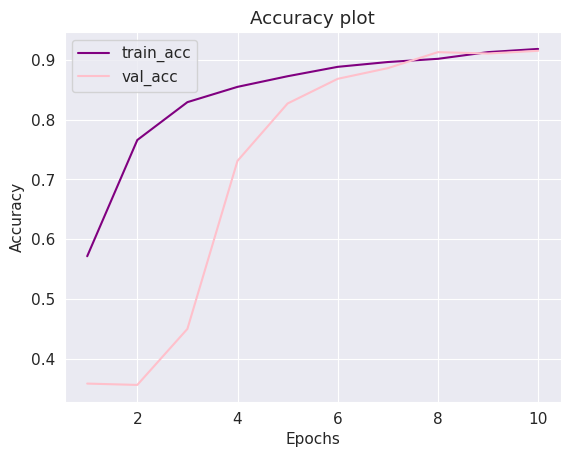

In [61]:
epochs = range (1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'], color = 'purple')
plt.plot(epochs, history.history['val_accuracy'], color = 'pink')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.legend(["train_acc","val_acc"])
plt.show()

**Loss plots**

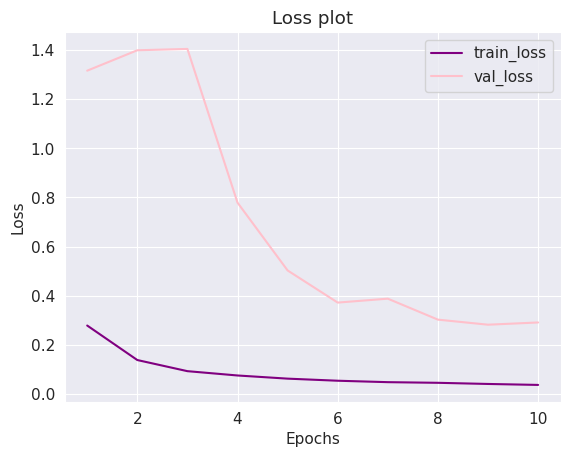

In [62]:
plt.plot(epochs, history.history['loss'], color = 'purple')
plt.plot(epochs, history.history['val_loss'], color = 'pink')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss plot")
plt.legend(["train_loss","val_loss"])
plt.show()

## 2. Handling class imbalance by Oversampling the minority classes (through duplications)

The approach involves creating new samples of data by duplicating the minority class to balance the distribution. Unlike SMOTE, synthetic samples of data are duplicated based on data space while SMOTE creates synthetic samples based on feature space.

In [63]:
train_df.head(2)

,path,label
6007,/kaggle/input/cxr-for-cptn/Dataset/NORMAL/IM-0283-0001.jpeg,NORMAL
2593,/kaggle/input/cxr-for-cptn/Dataset/NORMAL/IM-0650-0001-0001.jpeg,NORMAL


<Axes: >

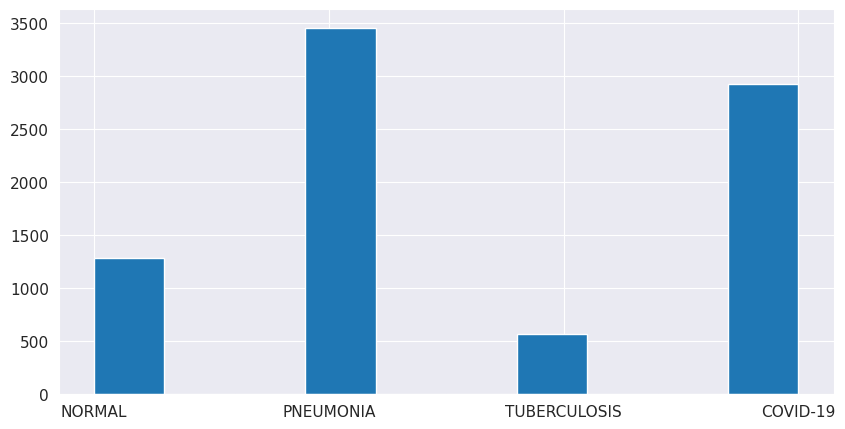

In [64]:
train_df['label'].hist(figsize = (10, 5))

In [65]:
train_df.pivot_table(index = 'label', aggfunc = len)

,path
label,
COVID-19,2928
NORMAL,1283
PNEUMONIA,3460
TUBERCULOSIS,567


**Data balancing**

Specifically, we create a function 'balance_data' to balance the training data by oversampling the minority class so that all classes have the same number of images as the maximum class. This is done to prevent the model from becoming biased towards the majority class and to improve overall classification performance.The function groups the data by label and then samples each group with replacement to create a new dataset with balanced classes. The resulting dataset is then shuffled and returned

In [66]:
def balance_data(class_size,df):
    train_df = df.groupby(['label']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['label'].hist(figsize = (10, 5))
    return train_df

New Data Size: 13840 Old Size: 8238


<Axes: >

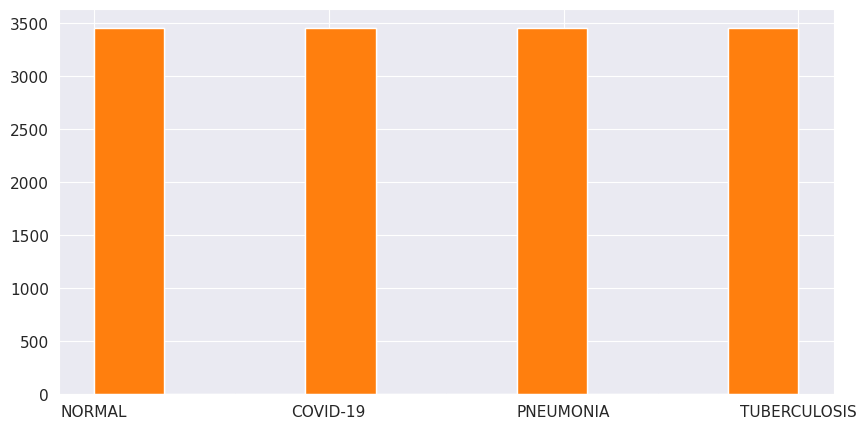

In [67]:
training_df = balance_data(train_df.pivot_table(index='label', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
training_df['label'].hist(figsize = (10, 5))

In [68]:
training_df.head()

,path,label
0,/kaggle/input/cxr-for-cptn/Dataset/NORMAL/NORMAL2-IM-0352-0001.jpeg,NORMAL
1,/kaggle/input/cxr-for-cptn/Dataset/COVID-19/COVID-2267.png,COVID-19
2,/kaggle/input/cxr-for-cptn/Dataset/PNEUMONIA/person1426_bacteria_3668.jpeg,PNEUMONIA
3,/kaggle/input/cxr-for-cptn/Dataset/PNEUMONIA/person90_virus_170.jpeg,PNEUMONIA
4,/kaggle/input/cxr-for-cptn/Dataset/COVID-19/COVID-1230.png,COVID-19


In [69]:
training_df['label'].value_counts()

NORMAL          3460
COVID-19        3460
PNEUMONIA       3460
TUBERCULOSIS    3460
Name: label, dtype: int64

In [71]:
# Create data for modeling
bal_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/bal_model.hdf5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max', verbose=1,
    save_best_only=True)

bal_training_data= data_generator(training_df, batch_size=configurations.BATCH_SIZE, augment=True, epochs=configurations.EPOCHS)
bal_train_steps = int(len(training_df)/configurations.BATCH_SIZE)
bal_val_data_generator = data_generator(val_df, batch_size=configurations.BATCH_SIZE, augment=False, epochs=configurations.EPOCHS)
bal_val_steps = int(len(val_df)/configurations.BATCH_SIZE)

bal_history = model.fit(bal_training_data, epochs=configurations.EPOCHS, steps_per_epoch=train_steps,
          validation_data=bal_val_data_generator, validation_steps=bal_val_steps, callbacks=[bal_model_checkpoint_callback])

Epoch 1/10
257/257 [==============================] - ETA: 0s - loss: 0.2565 - accuracy: 0.9088
Epoch 1: val_accuracy improved from -inf to 0.95424, saving model to /kaggle/working/bal_model.hdf5
257/257 [==============================] - 121s 416ms/step - loss: 0.2565 - accuracy: 0.9088 - val_loss: 0.1331 - val_accuracy: 0.9542
Epoch 2/10
257/257 [==============================] - ETA: 0s - loss: 0.1292 - accuracy: 0.9588
Epoch 2: val_accuracy improved from 0.95424 to 0.96317, saving model to /kaggle/working/bal_model.hdf5
257/257 [==============================] - 105s 411ms/step - loss: 0.1292 - accuracy: 0.9588 - val_loss: 0.0955 - val_accuracy: 0.9632
Epoch 3/10
257/257 [==============================] - ETA: 0s - loss: 0.0934 - accuracy: 0.9700
Epoch 3: val_accuracy improved from 0.96317 to 0.96987, saving model to /kaggle/working/bal_model.hdf5
257/257 [==============================] - 106s 414ms/step - loss: 0.0934 - accuracy: 0.9700 - val_loss: 0.0839 - val_accuracy: 0.9699
E

In [72]:
bal_val_data_generator1 = data_generator(val_df, batch_size=configurations.BATCH_SIZE, augment=False, epochs=1)
bal_val_steps = int(len(val_df)/configurations.BATCH_SIZE)

y_pred1 = []
y_true1 = []

for x,y in tqdm(bal_val_data_generator1, total=bal_val_steps):
    pred1 = model.predict(x)
    pred1 = np.argmax(pred1, axis=-1)
    for i in pred1:
        y_pred1.append(label_decoder[i])
    for i in y:
        y_true1.append(label_decoder[i])
clear_output()
print(classification_report(y_true1, y_pred1, digits=4))

              precision    recall  f1-score   support

    COVID-19     0.9878    0.9908    0.9893       326
      NORMAL     0.9568    0.9366    0.9466       142
   PNEUMONIA     0.9766    0.9766    0.9766       385
TUBERCULOSIS     0.9231    0.9524    0.9375        63

    accuracy                         0.9738       916
   macro avg     0.9611    0.9641    0.9625       916
weighted avg     0.9738    0.9738    0.9738       916



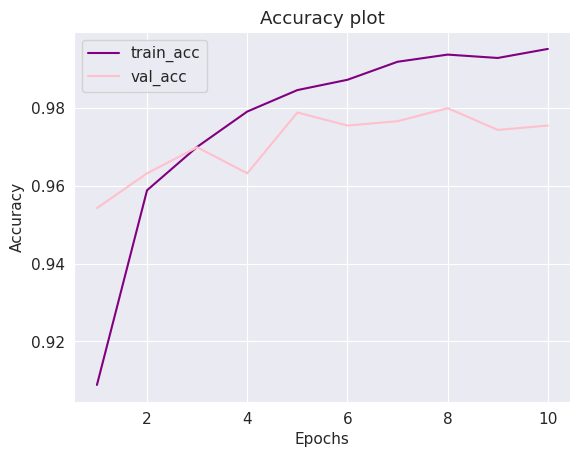

In [73]:
epochs = range (1, len(bal_history.history['accuracy']) + 1)
plt.plot(epochs, bal_history.history['accuracy'], color = 'purple')
plt.plot(epochs, bal_history.history['val_accuracy'], color = 'pink')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.legend(["train_acc","val_acc"])
plt.show()

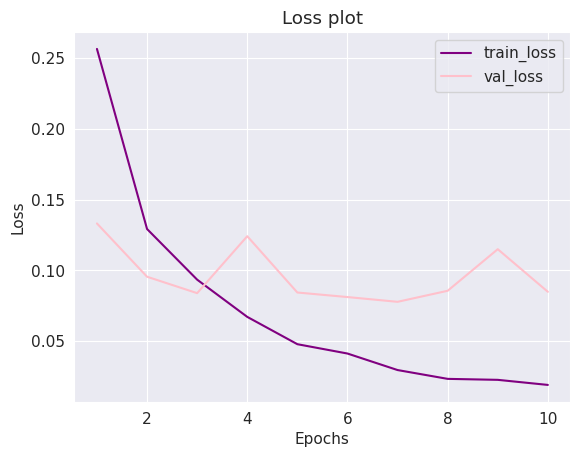

In [74]:
plt.plot(epochs, bal_history.history['loss'], color = 'purple')
plt.plot(epochs, bal_history.history['val_loss'], color = 'pink')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss plot")
plt.legend(["train_loss","val_loss"])
plt.show()

## 3. Handling class imbalance with data augmentation

In [75]:
def augment_ds(image):
    datagen1 = ImageDataGenerator(
    brightness_range = configurations.BRIGHTNESS,
    rotation_range = 20,
    horizontal_flip = True,
    zoom_range = 0.2,
    shear_range = 0.2,
    fill_mode = 'nearest'
    )
    # Convert input image from numpy to PIL Image
    image1 = np.expand_dims(image, axis=0)
    # Apply Transformations
    image1 = datagen1.flow(image1, batch_size=1)[0][0]
    return image1

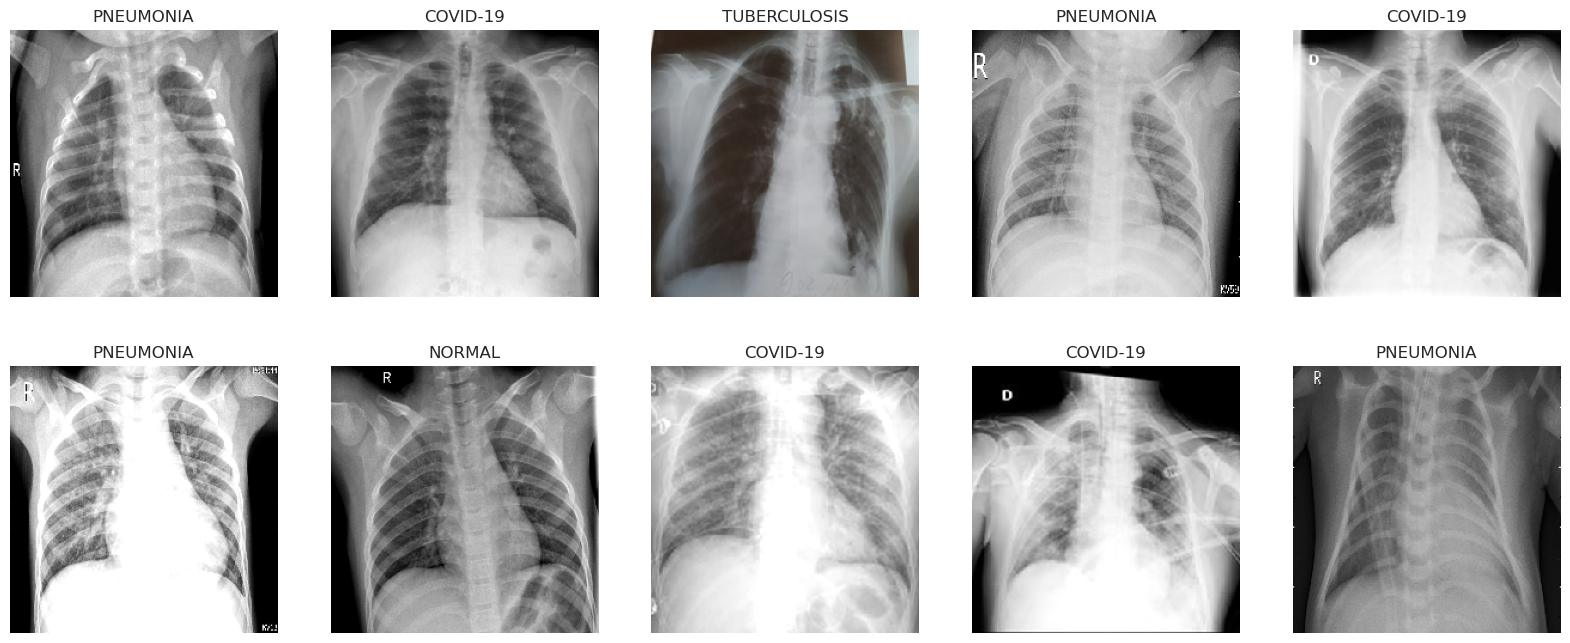

In [76]:
def open_images1(paths, augment=True):
    '''
    Given a list of paths to images, this function returns the images as arrays, and conditionally augments them
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(configurations.IMAGE_SIZE,configurations.IMAGE_SIZE))
        if augment:
            image = augment_ds(image)
        image = np.array(image)
        image = image/image.max()
        images.append(image)
    return np.array(images)

# Randomly select and plot a few images with augmentation
k1 = random.randint(0,5000)
image_paths1 = list(train_df.path[k:k+10])
labels1 = list(train_df.label[k:k+10])
images1 = open_images1(image_paths1, augment=True)
plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(20, 8))

for i in range(0, 10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(labels[i])
plt.show()

In [77]:
# define augment generators for dataset
def aug_data_generator(df, batch_size=configurations.BATCH_SIZE, augment=True, epochs=configurations.EPOCHS):
    for e in range(epochs):
        for x in range(0,len(df), batch_size):
            image_paths = df.path[x:x+batch_size]
            images = open_images1(image_paths, augment=augment)
            labels = df.label[x:x+batch_size]
            labels = [label_encoder[label] for label in labels]
            yield images, np.array(labels)

In [78]:
# Creating generators for training and validation sets
train_aug_data_generator = aug_data_generator(train_df, batch_size=configurations.BATCH_SIZE, augment=True, epochs=configurations.EPOCHS)
train_aug_steps = int(len(train_df)/configurations.BATCH_SIZE)

val_aug_data_generator = aug_data_generator(val_df, batch_size=configurations.BATCH_SIZE, augment=False, epochs=configurations.EPOCHS)
val_aug_steps = int(len(val_df)/configurations.BATCH_SIZE)

In [79]:
# use the model ResNet model made
model_checkpoint_callback_aug = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/aug_model.hdf5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max', verbose=1,
    save_best_only=True)

history_aug = model.fit(train_aug_data_generator, epochs=configurations.EPOCHS, steps_per_epoch=train_aug_steps,
          validation_data=val_aug_data_generator, validation_steps=val_aug_steps, callbacks=[model_checkpoint_callback_aug])

Epoch 1/10
257/257 [==============================] - ETA: 0s - loss: 0.2147 - accuracy: 0.9283
Epoch 1: val_accuracy improved from -inf to 0.96205, saving model to /kaggle/working/aug_model.hdf5
257/257 [==============================] - 177s 691ms/step - loss: 0.2147 - accuracy: 0.9283 - val_loss: 0.1209 - val_accuracy: 0.9621
Epoch 2/10
257/257 [==============================] - ETA: 0s - loss: 0.1531 - accuracy: 0.9506
Epoch 2: val_accuracy did not improve from 0.96205
257/257 [==============================] - 174s 679ms/step - loss: 0.1531 - accuracy: 0.9506 - val_loss: 0.2016 - val_accuracy: 0.9453
Epoch 3/10
257/257 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.9520
Epoch 3: val_accuracy improved from 0.96205 to 0.97656, saving model to /kaggle/working/aug_model.hdf5
257/257 [==============================] - 174s 678ms/step - loss: 0.1380 - accuracy: 0.9520 - val_loss: 0.0760 - val_accuracy: 0.9766
Epoch 4/10
257/257 [==============================] -

In [80]:
val_data_generator_1 = aug_data_generator(val_df, batch_size=configurations.BATCH_SIZE, augment=False, epochs=1)
val_aug_steps_1 = int(len(val_df)/configurations.BATCH_SIZE)

y_pred_aug = []
y_true_aug = []

for x,y in tqdm(val_data_generator_1, total=val_aug_steps_1):
    pred_aug = model.predict(x)
    pred_aug = np.argmax(pred_aug, axis=-1)
    for i in pred_aug:
        y_pred_aug.append(label_decoder[i])
    for i in y:
        y_true_aug.append(label_decoder[i])
clear_output()
print(classification_report(y_true_aug, y_pred_aug, digits=4))

              precision    recall  f1-score   support

    COVID-19     0.9790    1.0000    0.9894       326
      NORMAL     0.9444    0.9577    0.9510       142
   PNEUMONIA     0.9843    0.9792    0.9818       385
TUBERCULOSIS     1.0000    0.8889    0.9412        63

    accuracy                         0.9771       916
   macro avg     0.9769    0.9565    0.9658       916
weighted avg     0.9773    0.9771    0.9769       916



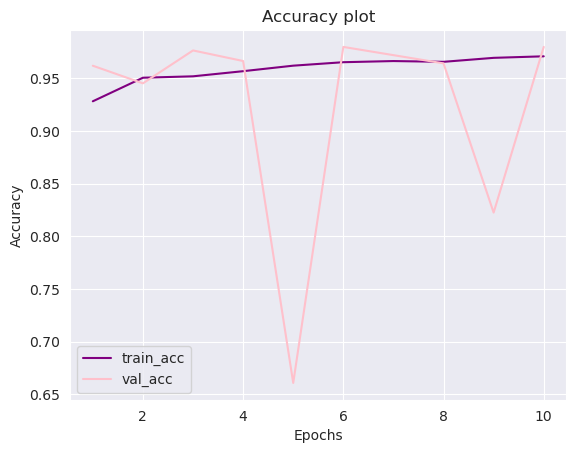

In [81]:
epochs = range (1, len(history_aug.history['accuracy']) + 1)
plt.plot(epochs, history_aug.history['accuracy'], color = 'purple')
plt.plot(epochs, history_aug.history['val_accuracy'], color = 'pink')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.legend(["train_acc","val_acc"])
plt.show()

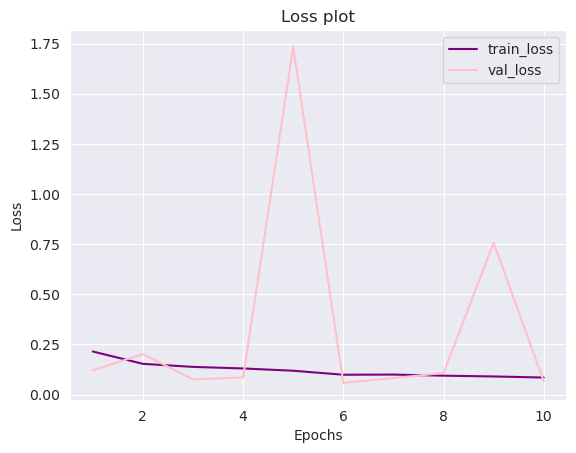

In [82]:
plt.plot(epochs, history_aug.history['loss'], color = 'purple')
plt.plot(epochs, history_aug.history['val_loss'], color = 'pink')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss plot")
plt.legend(["train_loss","val_loss"])
plt.show()